### Load packages
Import Python packages that are used for the analysis.

In [92]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [93]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [119]:
tile = '0_-13'

In [120]:
# Get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
        
          

In [121]:
bounds = get_tile_bounds(tile)
print(bounds)

{'minx': 0, 'miny': -1300000, 'maxx': 100000, 'maxy': -1200000}


### Load all available ARD baseline data

In [122]:
bounds['minx'],bounds['maxx']

(0, 100000)

In [123]:
# Load geomedian data
ds_gm = dc.load(product="ls8_nbart_geomedian_annual",
             x=(bounds['minx'],bounds['maxx']),
             y=(bounds['miny'],bounds['maxy']),
             time=("2015-01-01", "2015-12-31"),
             crs='EPSG:3577',
             output_crs = 'EPSG:3577',
             #min_gooddata = 0.5,
             #bands = ['nbart_red','nbart_green','nbart_blue','nbart_nir','nbart_swir_1','nbart_swir_2'],
             resolution=(-100, 100))

print(ds_gm)

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 336 383 482 523 477 ... 412 411 430 419 414
    green        (time, y, x) int16 473 516 572 566 531 ... 579 590 615 608 599
    red          (time, y, x) int16 318 343 350 332 325 ... 686 693 731 710 703
    nir          (time, y, x) int16 2327 2024 966 244 ... 2132 2122 2227 2263
    swir1        (time, y, x) int16 659 586 309 126 206 ... 1971 2056 2003 2009
    swir2        (time, y, x) int16 296 274 159 86 114 ... 1246 1336 1258 1241
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


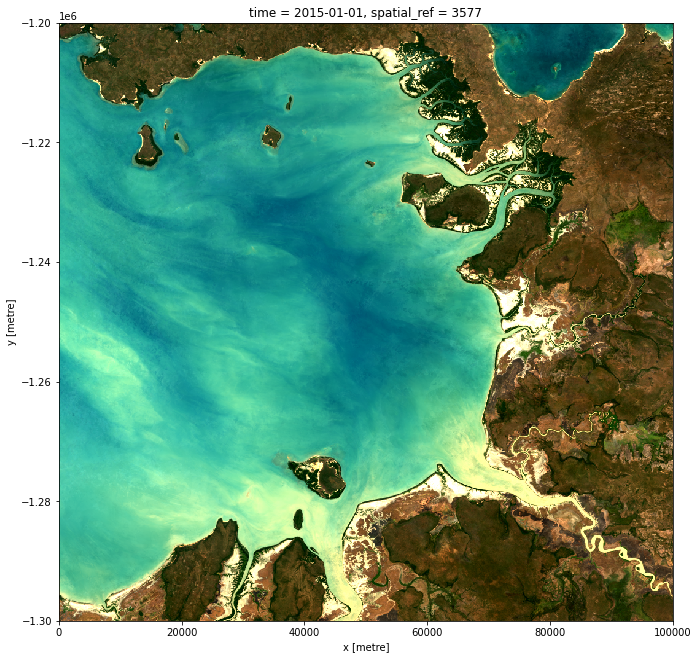

In [124]:
rgb(ds_gm,bands=['red','green','blue'],size=11)

In [125]:
# Load fractional cover data
fc = dc.load(product="fc_percentile_albers_annual",
             x=(bounds['minx'],bounds['maxx']),
             y=(bounds['miny'],bounds['maxy']),
             time=("2015-01-01", "2015-12-31"),
             crs='EPSG:3577',
             output_crs = 'EPSG:3577',
             #min_gooddata = 0.5,
             #bands = ['nbart_red','nbart_green','nbart_blue','nbart_nir','nbart_swir_1','nbart_swir_2'],
             resolution=(-100, 100))
fc

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
    spatial_ref  int32 3577
Data variables:
    BS_PC_10     (time, y, x) int16 9 8 4 -1 1 4 1 -1 8 11 ... 4 3 3 2 2 3 4 3 3
    PV_PC_10     (time, y, x) int16 73 67 71 -1 79 75 75 ... 25 27 30 27 31 34
    NPV_PC_10    (time, y, x) int16 0 1 0 -1 0 0 0 -1 ... 28 28 27 28 27 27 25
    BS_PC_50     (time, y, x) int16 16 14 10 -1 9 14 11 ... 20 14 12 12 13 12 11
    PV_PC_50     (time, y, x) int16 80 84 88 -1 92 85 88 ... 39 41 43 41 44 47
    NPV_PC_50    (time, y, x) int16 1 2 1 -1 0 0 0 -1 ... 44 45 45 44 44 42 42
    BS_PC_90     (time, y, x) int16 26 32 30 -1 24 28 27 ... 27 25 23 25 22 19
    PV_PC_90     (time, y, x) int16 90 92 98 -1 100 96 100 ... 68 69 67 66 66 69
    NPV_PC_90    (time, y, x) int16 7 7 6 -1 3 4 1 -1 ... 49 50 50 49 49 48 48
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

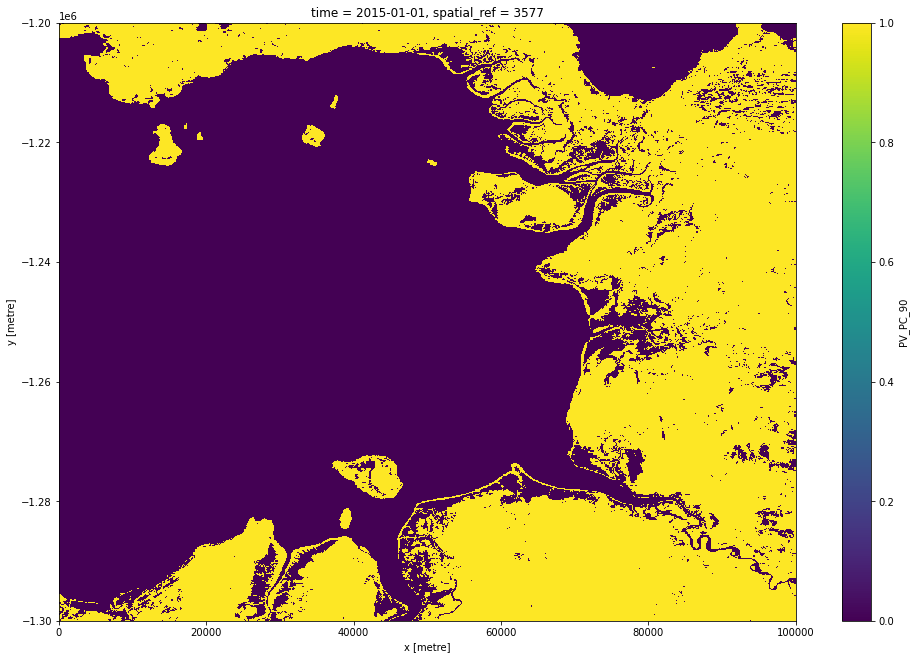

In [126]:
test = fc.PV_PC_90 > 50
test.plot(size=11)

In [127]:
# # Load single dates

# ds_ard = load_ard(dc=dc,
#                  products=["ga_ls8c_ard_3"], #"ls8_nbart_geomedian_annual"
#                  x=(bounds['minx'],bounds['maxx']),
#                  y=(bounds['miny'],bounds['maxy']),
#                  time=("2015-01-01", "2015-06-30"),
#                  crs='EPSG:3577',
#                  output_crs = 'EPSG:3577',
#                  min_gooddata = 0.5,
#                  group_by = 'solar_day',
#                  measurements= ['nbart_red','nbart_green','nbart_blue','nbart_nir','nbart_swir_1','nbart_swir_2'],
#                  resolution=(-100, 100))

# print(ds_ard)

In [128]:
# Load single dates

wofs = dc.load(product="wofs_annual_summary",
             x=(bounds['minx'],bounds['maxx']),
             y=(bounds['miny'],bounds['maxy']),
             time=("2015-01-01", "2015-12-31"),
             crs='EPSG:3577',
             output_crs = 'EPSG:3577',
             #min_gooddata = 0.5,
             #bands = ['nbart_red','nbart_green','nbart_blue','nbart_nir','nbart_swir_1','nbart_swir_2'],
             resolution=(-25, 25))

print(wofs)

<xarray.Dataset>
Dimensions:      (time: 1, x: 4000, y: 4000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 12.5 37.5 62.5 ... 9.994e+04 9.996e+04 9.999e+04
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 1 1 1 1 1 2 21 26 27 ... 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 27 26 26 26 26 27 27 ... 50 50 50 48 47 47
    frequency    (time, y, x) float32 0.037037037 0.03846154 ... 0.0 0.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


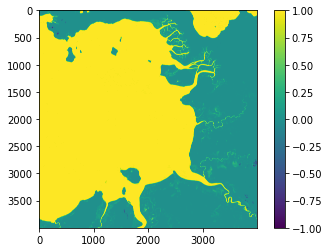

In [129]:
plt.imshow(wofs.frequency.isel(time=0))
plt.colorbar()

In [130]:
# rgb(ds_ard.isel(time=2)) #bands=['red','green','blue']

## Generate TCW

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


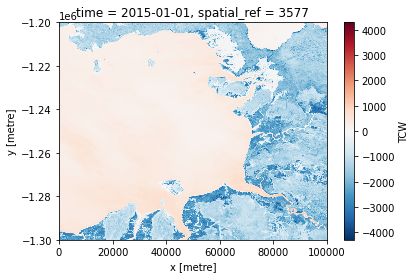

In [131]:
# Calculate TCW for the baseline images
ds_gm = calculate_indices(ds_gm, 
                              index='TCW', 
                              collection='ga_ls_3', 
                              drop=False,
                              normalise = False)
ds_gm.isel(time=0).TCW.plot()

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


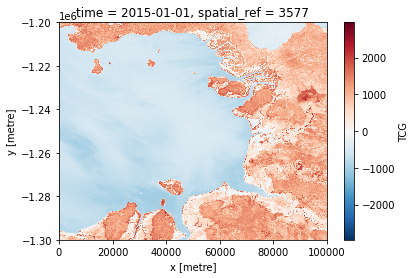

In [132]:
# Calculate TCG for the baseline images
ds_gm = calculate_indices(ds_gm, 
                              index='TCG', 
                              collection='ga_ls_3', 
                              drop=False,
                              normalise = False)
ds_gm.isel(time=0).TCG.plot()

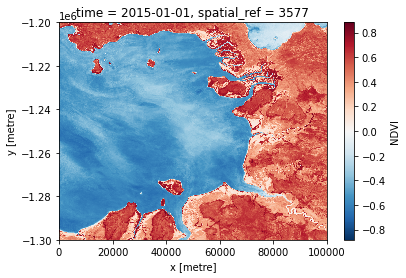

In [133]:
# Calculate TCG for the baseline images
ds_gm = calculate_indices(ds_gm, 
                              index='NDVI', 
                              collection='ga_ls_3', 
                              drop=False,
                              normalise = False)
ds_gm.isel(time=0).NDVI.plot()

In [134]:
# # Calculate TCW for the baseline images
# ds_ard = calculate_indices(ds_ard, 
#                               index='TCW', 
#                               collection='ga_ls_3', 
#                               drop=False,
#                               normalise = False)

# ds_ard.isel(time=1).TCW.plot()

In [135]:
# print('min',ds_gm.red.values.min(),'max',ds_gm.red.values.max())
# print('min',np.nanmin(ds_ard.nbart_red.values),'max',np.nanmax(ds_ard.nbart_red.values))

In [136]:
print('min',np.nanmin(ds_gm.TCW.values),'max',np.nanmax(ds_gm.TCW.values))
# print('min',np.nanmin(ds_ard.TCW.values),'max',np.nanmax(ds_ard.TCW.values))

min -4293.8501 max 1139.4484


## Apply threshold to TCW

Set and apply the NBR threshold.
Here we set it to 0.3, but this will need adjustment depending on the use case.  

In [137]:
ds_gm.TCW

<xarray.DataArray 'TCW' (time: 1, y: 1000, x: 1000)>
array([[[  -53.5971,   -20.8459,    85.8961, ...,   114.3341,
           122.3225,   107.1835],
        [ -188.7976,  -148.0697,  -182.3941, ...,   110.9632,
           107.5359,   112.0704],
        [ -253.2346,  -350.4225,  -606.3531, ...,   136.8067,
           121.1671,   125.0432],
        ...,
        [-3042.2062, -2172.4978, -1549.0698, ..., -1539.5146,
         -1571.2513, -1429.7001],
        [-2816.2786, -1963.8929,  -598.5378, ..., -1563.7232,
         -1479.5569, -1483.0618],
        [-2606.3911, -1066.057 ,  -803.1103, ..., -1512.6365,
         -1420.4529, -1412.5606]]])
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -1.2e+06 -1.2e+06 -1.2e+06 ... -1.3e+06 -1.3e+06
  * x            (x) float64 50.0 150.0 250.0 ... 9.975e+04 9.985e+04 9.995e+04
    spatial_ref  int32 3577

In [138]:
# # Calculate TCW for the baseline images
# ds_gm = calculate_indices(ds_gm, 
#                               index='NDVI', 
#                               collection='ga_ls_3', 
#                               drop=False,
# #                               normalise = False
#                          )

# ds = ds_gm.isel(time=0)

# tcw_t = 62
# ndvi_t = -0.19

# river_wetland = np.where(ds.TCW>62,1,0)
# lake_wetland = np.where((ds.TCW<=62)&(ds.NDVI<-0.19),1,0)

# plt.imshow(lake_wetland)
# plt.colorbar()

In [147]:
tcw = ds_gm.TCW
tcg = ds_gm.TCG
ndvi = ds_gm.NDVI
fc_mask = fc.PV_PC_90

# Set threshold
threshold_tcw = -600
threshold_tcg = 1300
threshold_ndvi = 0.7
threshold_fc = 50

# Apply threshold
water = tcw > threshold_tcw
forest = tcg > threshold_tcg
forest_ndvi = ndvi > threshold_ndvi
forest_fc = fc_mask > threshold_fc

# Mask post-fire true colour image
masked_water = tcw.where(water==1)
masked_forest = tcg.where(forest==1)
masked_forest_ndvi = ndvi.where(forest_ndvi==1)
masked_fc = fc_mask.where(forest_fc==1)

In [148]:
np.unique(masked_water)

array([-599.9932, -599.9835, -599.9814, ...,       nan,       nan,
             nan])

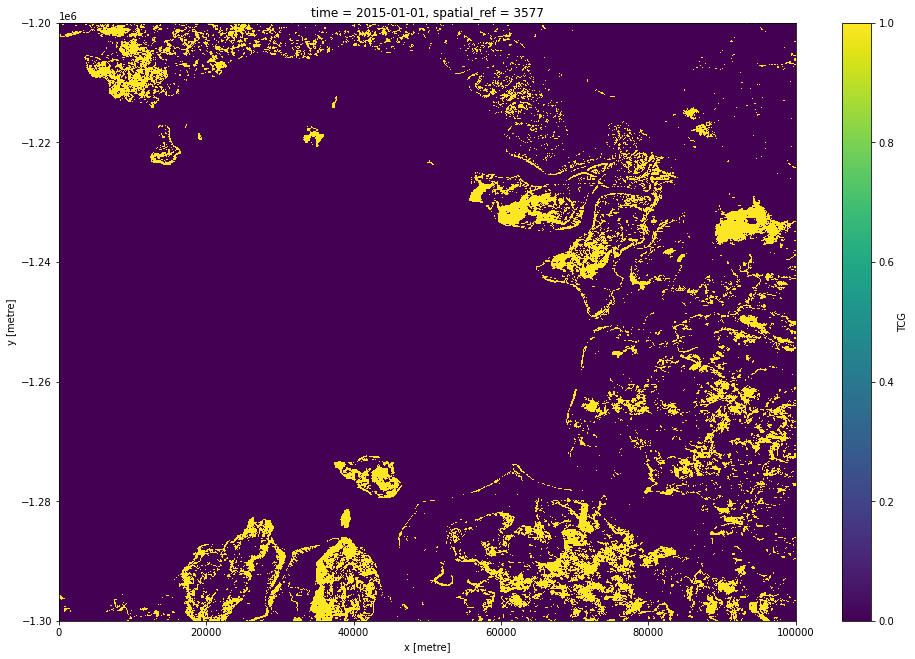

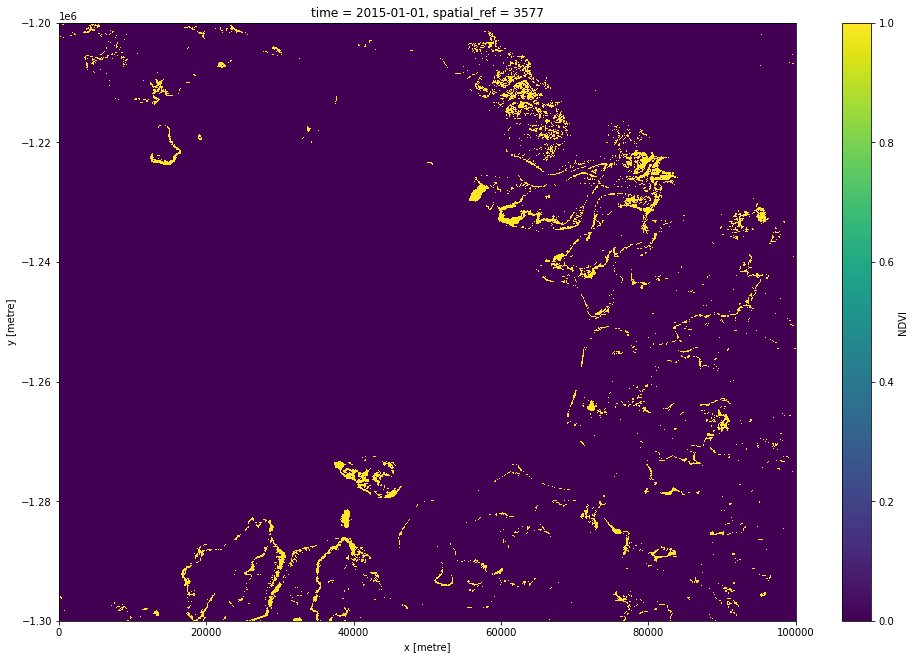

In [149]:
forest.plot(size=11)
forest_ndvi.plot(size=11)

In [150]:
np.unique(water_only)

array([0, 1])

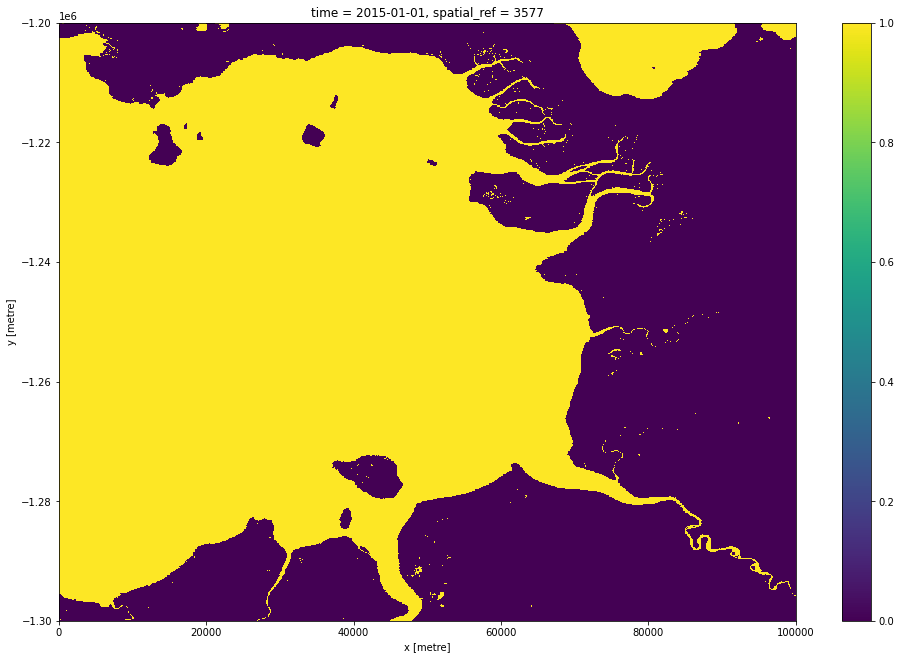

In [151]:
water_only = np.where(forest_fc==1,0,water)
# plt.imshow(water_only.squeeze())
water_arr = xr.DataArray(water_only,water.coords)
water_arr.plot(size=11)

## Export results to GeoTIFF

The baseline reference image and the post fire image will both be saved as a multiband GeoTIFF with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The thresholded burnt area image will be saved as a single band image, where a value of 1 = burnt and a value of 0 = not burnt.

In [152]:
# Define an area name to be used in saved file names
area_name = '11_-40'

# # Write baseline reference image to multi-band GeoTIFF
# write_geotiff(f'wofs_11_-40.tif', wofs.frequency.isel(time=0))

# # Write post fire image to multi-band GeoTIFF
# write_geotiff(f'{area_name}_post_fire_image.tif', post_image)

# Turn delta NBR into a Xarray Dataset for export to GeoTIFF
dnbr_dataset = wofs.frequency.isel(time=0).to_dataset(name='burnt_area')
write_geotiff(f'{area_name}_wofs.tif', dnbr_dataset)

/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)